In [148]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set()
sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
plt.rcParams['axes.facecolor'] = 'ebe8f2'

%matplotlib inline

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [149]:
def read(path):
    df = pd.read_csv(path)
    df = df.sort_values(by=["rate", "start"])
    df['latency'] = df['latency'] * 1000
    return df

def latency_scatter(dfs):
    """Create a scatter plot with all measured latencies"""
    for name, df in dfs.items():
        plt.scatter(df['rate'], df['latency'], alpha=0.01, marker='.', label=name)
    plt.xlabel("Req/s")
    plt.ylabel("Latency (s)")
    plt.legend()

def quantile_plot(dfs, y_max=400, q_low=0.2, q_high=0.8):
    """Create a quantile plot with a line for the median and a filled area for a quantile range"""
    f, a = plt.subplots(figsize=(12,8), dpi= 100)
    handles = []
    names = []
    color_iter = iter(color_cycle)
    for name, df in dfs.items():
        color = next(color_iter)
        grouped_latency = df.groupby("rate")["latency"]
        q20 = grouped_latency.quantile(q_low)
        q50 = grouped_latency.quantile(0.5)
        q80 = grouped_latency.quantile(q_high)
        fill = a.fill_between(q20.index, q20, q80, alpha=0.2, color=color)
        med = a.plot(q50.index, q50, color=color)
        dummy_fill = a.fill(np.NaN, np.NaN, alpha=0.2, color=color)
        handles.append((med[0], dummy_fill[0]))
        names.append(name)
    a.set_xlabel("Rate (requests/s)", fontsize=14)
    a.set_ylabel("Latency (ms)", fontsize=14)
    a.set_ylim([0, y_max])
    a.legend(handles, names)
    
def rate_consistency(dfs):
    """Print request rate consistency. This measures the qualtiy of the test."""
    for name, df in dfs.items():
        starts = df.sort_values("start")[["rate", "start"]]
        diffqs = {}
        for rate in df['rate'].unique():
            diff = df[df["rate"] == rate].sort_values("start")["start"].diff()
            q = diff.quantile(0.5)
            diffqs[rate] = (round(q, 5), round(1/rate, 3), round(abs(q - 1/rate), 5))
        plt.plot(diffqs.keys(), [x[-1] for x in diffqs.values()], label=name)
    plt.title("Deviation from ideal request frequency")
    plt.xlabel("Rate (requests/s)")
    plt.ylabel("Deviation (s)")

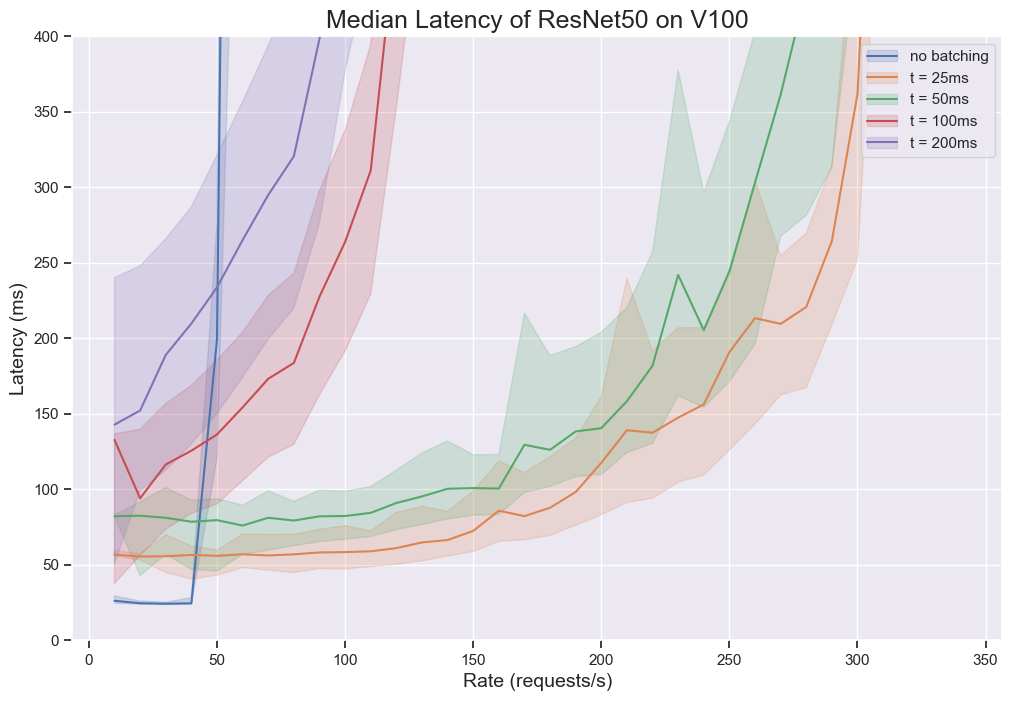

In [154]:
w1 = {
    "no batching": read("v100-w1"), 
    "t = 25ms": read("v100-b-t25-w1"),
    "t = 50ms": read("v100-b-t50-w1"), 
    "t = 100ms": read("v100-b-t100-w1"),
    "t = 200ms": read("v100-b-t200-w1"),
}
quantile_plot(w1)
plt.title("Median Latency of ResNet50 on V100", fontsize=18);

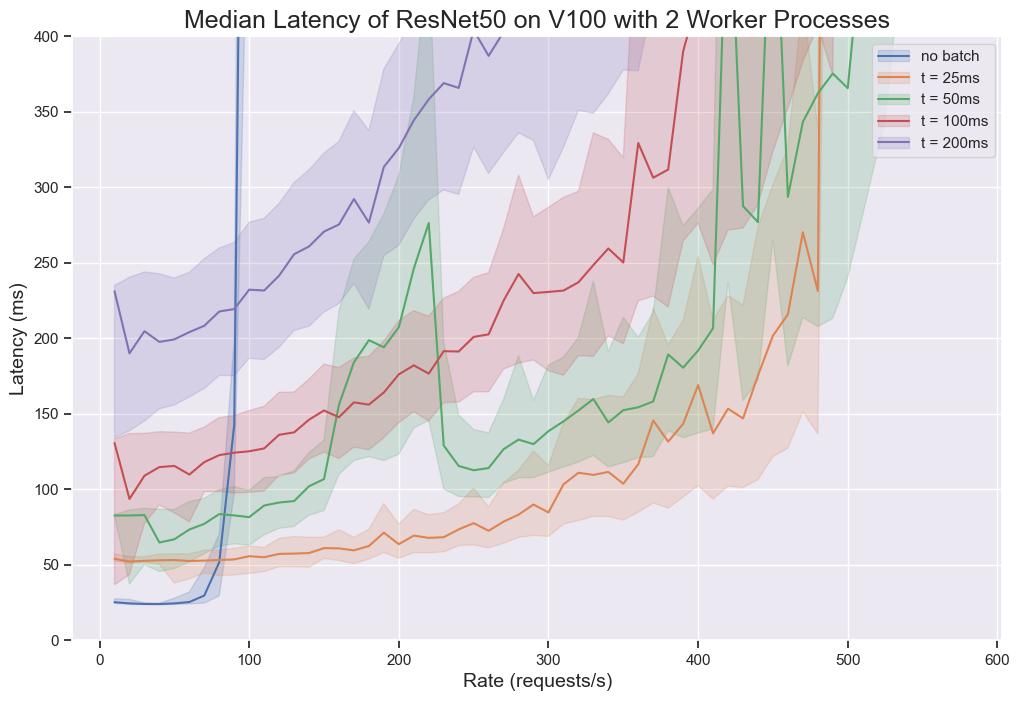

In [156]:
w2 = {
    "no batch": read("v100-w2"), 
    "t = 25ms": read("v100-b-t25-w2"),
    "t = 50ms": read("v100-b-t50-w2"), 
    "t = 100ms": read("v100-b-t100-w2"),
    "t = 200ms": read("v100-b-t200-w2"),
}
quantile_plot(w2)
plt.title("Median Latency of ResNet50 on V100 with 2 Worker Processes", fontsize=18);

['no batch 1 worker', 't=25 1 worker', 't=50 1 worker', 't=100 1 worker', 't=200 1 worker', 'no batch 2 workers', 't=25 2 workers', 't=50 2 workers', 't=100 2 workers', 't=200 2 workers']


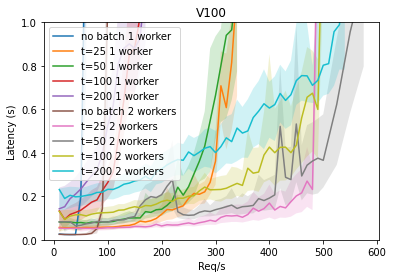

In [45]:
all_ = {}
for k, v in w1.items():
    all_[f"{k} 1 worker"] = v
for k, v in w2.items():
    all_[f"{k} 2 workers"] = v
print(list(all_.keys()))
quantile_plot(all_)
plt.title("V100");

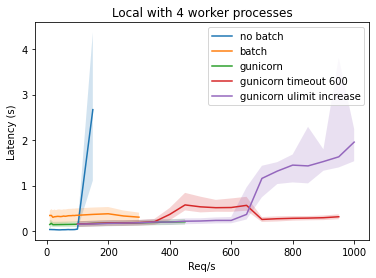

In [212]:
localp4 = {"no batch": read("local-p4"), "batch": read("localbatch-p4"), "gunicorn": read("local-p4-gunicorn"), "gunicorn timeout 600": read("local-p4-gunicorn-timeout"),
          "gunicorn ulimit increase": read("local-p4-gunicorn-ulimit-1024-timeout")
          }
quantile_plot(localp4)
plt.title("Local with 4 worker processes");

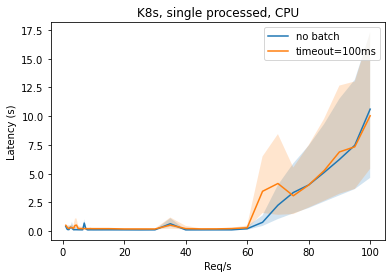

In [209]:
singleproc = {"no batch": read("singlenobatch"), "timeout=100ms": read("singlebatch-t100")}
quantile_plot(singleproc)
plt.title("K8s, single processed, CPU");

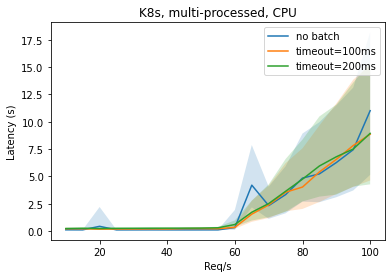

In [201]:
singleproc = {"no batch": read("multinobatch"), "timeout=100ms": read("multibatch-t100"), "timeout=200ms": read("multibatch-t200")}
quantile_plot(singleproc)
plt.title("K8s, multi-processed, CPU");

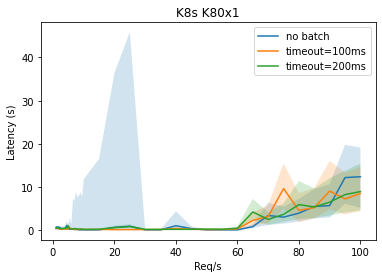

In [203]:
singleproc = {"no batch": read("gpunobatch"), "timeout=100ms": read("gpu-b100-t100"), "timeout=200ms": read("gpu-b100-t200")}
quantile_plot(singleproc)
plt.title("K8s K80x1");

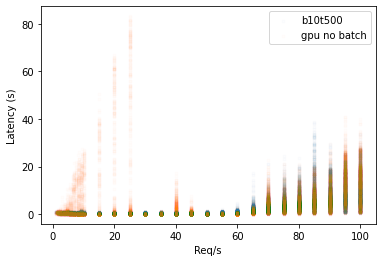

In [187]:
latency_scatter(dfs)

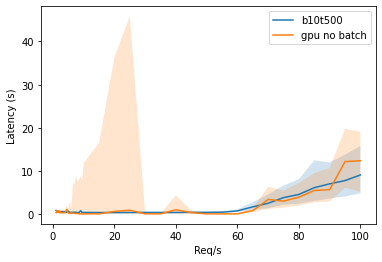

In [188]:
quantile_plot(dfs)

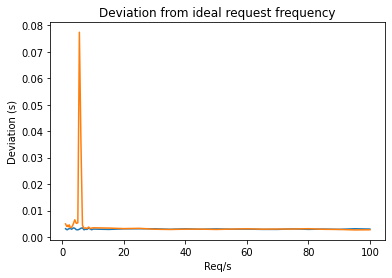

In [189]:
rate_consistency(dfs)